In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score, mean_squared_error
from keras.layers import Bidirectional

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from pylab import rcParams

Using TensorFlow backend.


In [3]:
df = pd.read_excel('Data_SL.xlsx', index_col='Time (UTC)', parse_dates=True)
df= df.iloc[:, 2:3]
df.head()

,prs(m)
Time (UTC),
2019-01-01 00:00:00,1.184
2019-01-01 00:01:00,1.190
2019-01-01 00:02:00,1.180
2019-01-01 00:03:00,1.187
2019-01-01 00:04:00,1.184


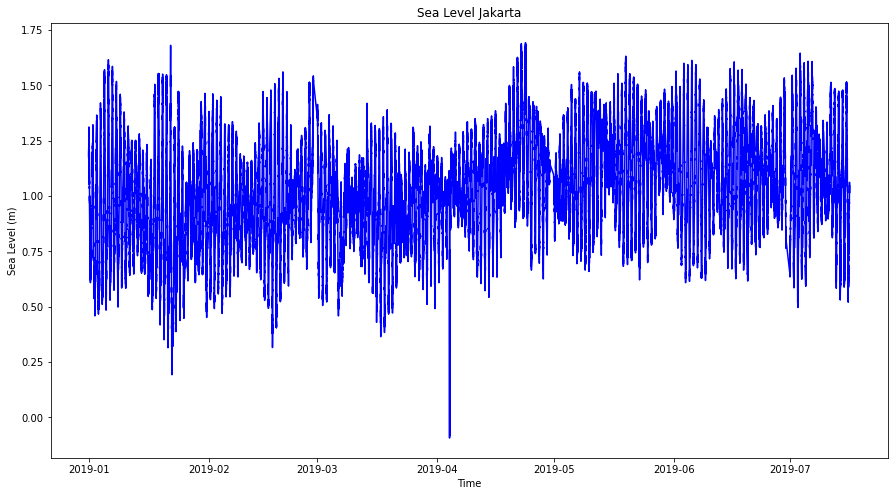

In [4]:
# Plot data sea level
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 15, 8
plt.title("Sea Level Jakarta")
plt.xlabel("Time")
plt.ylabel("Sea Level (m)")
plt.plot(df.index, df['prs(m)'], 'b-')
plt.show()

In [5]:
df=df.resample('h').mean()
df['prs(m)'].interpolate(method='spline',order=3,inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4713 entries, 2019-01-01 00:00:00 to 2019-07-16 08:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prs(m)  4713 non-null   float64
dtypes: float64(1)
memory usage: 73.6 KB


In [6]:
data=df.iloc[2880:4320]

In [7]:
train_data = data[:len(data)-288]
test_data = data[len(data)-288:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
scaled_test_data['prs(m)'].plot(figsize = (16,5), label='data test', legend=True)
scaled_train_data['prs(m)'].plot(label = 'data train', legend=True);

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [10]:
train_data

,prs(m)
Time (UTC),
2019-05-01 00:00:00,1.076000
2019-05-01 01:00:00,1.046200
2019-05-01 02:00:00,1.028533
2019-05-01 03:00:00,0.983067
2019-05-01 04:00:00,0.962600
...,...
2019-06-17 19:00:00,1.248167
2019-06-17 20:00:00,1.154283
2019-06-17 21:00:00,1.031717


In [7]:
lstm_model = tf.keras.models.load_model('lstmmodel2.h5')

lstm_model.summary()
n_input = 12
n_features= 1
lstm_model.load_weights('lstmweights2.h5')
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 40)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 40)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [8]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [9]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

C:\Users\MAULANA\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prs(m),LSTM_Predictions
Time (UTC),,
2019-06-18 00:00:00,0.741050,0.693657
2019-06-18 01:00:00,0.726117,0.662836
2019-06-18 02:00:00,0.726417,0.664971
2019-06-18 03:00:00,0.779333,0.689173
2019-06-18 04:00:00,0.851433,0.728652
...,...,...
2019-06-29 19:00:00,1.120083,1.125480
2019-06-29 20:00:00,1.013633,1.009643
2019-06-29 21:00:00,0.903917,0.895490


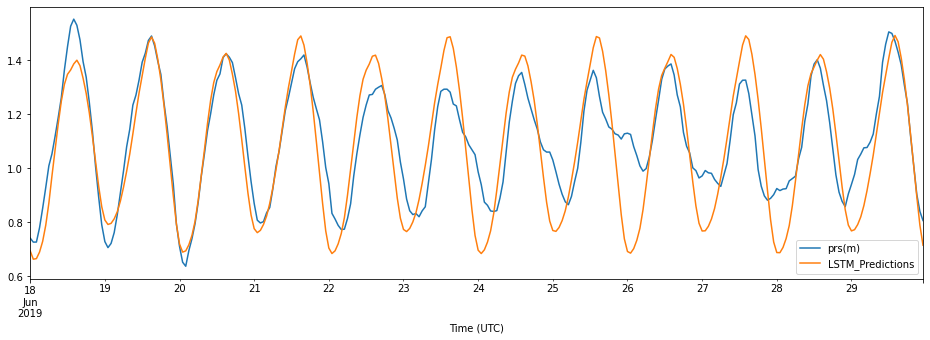

In [10]:
test_data['prs(m)'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [11]:
from sklearn.metrics import r2_score
r2=r2_score(test_data['prs(m)'], test_data["LSTM_Predictions"])
MSE_score = mean_squared_error(test_data['prs(m)'], test_data["LSTM_Predictions"])
RMSE_score = np.sqrt(MSE_score)
correlation_matrix = np.corrcoef(test_data['prs(m)'], test_data["LSTM_Predictions"])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r2_score = abs(r2)
print("MSE Score of LSTM model_1 = ",MSE_score)
print("RMSE Score of LSTM model_1 = ",RMSE_score)
print("R2 Score of LSTM model_1 = ",r_squared)

MSE Score of LSTM model_1 =  0.015919018260100386
RMSE Score of LSTM model_1 =  0.12617059189882715
R2 Score of LSTM model_1 =  0.7699166854610725


In [12]:
correlation_matrix = np.corrcoef(test_data['prs(m)'], test_data["LSTM_Predictions"])

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2


print(r_squared)

0.7699166854610725
